GitHub: https://github.com/boris-gans/ML-fundamentals-2025.git

In [ ]:
%pip install pandas
%pip install xlrd
%pip install category-encoders
%pip install imblearn
%pip install seaborn

In [10]:
import pandas
import xlrd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from category_encoders import BinaryEncoder
from imblearn.over_sampling import ADASYN
from collections import Counter
plt.style.use('ggplot')

# Task 1: EDA
Load the dataset

In [5]:
data = pandas.read_csv("/Users/borisgans/IE/ML/assingments/assignment_2/bike+sharing+dataset/hour.csv")
data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


Lets explore each column and identify:
>- Missing values
>- Which are categorical and which are numerical

This will help me in identifying which columns I should delete, impute (non-statistically only, proper data imputation occurs during Task 3) 

In [7]:
print(f"\nColumns: {data.columns}")

# This is great for distinguishing between the categorical and numerical variables
print(f"\nData types:\n {data.dtypes}")


Columns: Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')

Data types:
 instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
hr              int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object


From the Readme.txt file we get the following list of column descriptions:

- instant: record index
- dteday : date
- season : season (1:spring, 2:summer, 3:fall, 4:winter)
- yr : year (0: 2011, 1:2012)
- mnth : month ( 1 to 12)
- hr : hour (0 to 23)
- holiday : weather day is holiday or not
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
+ weathersit : 
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : Normalized temperature in Celsius. The values are divided to 41 (max)
- atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered

Already we can see that lots of data cleaning has already been done on this dataset. There is only one non-numerical column, dteday, which has already been split into the season, yr, and mnth columns. Plus, the columns holiday, weekday and workingday have been added to provide better insight into the value of date.

Additionally, it seems that most other columns have already been encoded and/or normalized as well, including: weathersit, temp, atemp, hum and windspeed. Lets explore each column further to validate this assumption.

In [8]:
print(data.describe())

          instant        season            yr          mnth            hr  \
count  17379.0000  17379.000000  17379.000000  17379.000000  17379.000000   
mean    8690.0000      2.501640      0.502561      6.537775     11.546752   
std     5017.0295      1.106918      0.500008      3.438776      6.914405   
min        1.0000      1.000000      0.000000      1.000000      0.000000   
25%     4345.5000      2.000000      0.000000      4.000000      6.000000   
50%     8690.0000      3.000000      1.000000      7.000000     12.000000   
75%    13034.5000      3.000000      1.000000     10.000000     18.000000   
max    17379.0000      4.000000      1.000000     12.000000     23.000000   

            holiday       weekday    workingday    weathersit          temp  \
count  17379.000000  17379.000000  17379.000000  17379.000000  17379.000000   
mean       0.028770      3.003683      0.682721      1.425283      0.496987   
std        0.167165      2.005771      0.465431      0.639357      0.

First thing that I notice is that there is not a single missing value in this dataset. Each column has exactly 17,379 non-null entries, corresponding with the value indicated on the Readme file. 

Also, it's easy to see that most values have already been encoded and/or normalized as well. The columns season, yr, mnth, hr, holiday, weekday, workingday, and weathersit have all been encoded. In workingday, for example, we can see that the min/max values are 0 and 1 and the values of each quartile are integers, telling me that this column takes on either a 0 or 1 (as if it were a boolean). The same applies for weathersit, except each value (1 through 4) corresponds to a certain weather condition, as indicated on the Readme file. The other columns, temp, atemp, hum and windspeed have all been normalized. Their max and min values are (almost) all 0 and 1, and on the Readme file its clearly indicated that each column has been divided by its maximum value, ensuring the new maximum values are now 1.

The creators of this dataset pursued normalization, rather than standarization, which is important to note. This may impact the performance of our models:
>- Since Linear Regression assumes its residuals are normally distributed, Standarization (rather than Normalization) helps make the cost function more symmetrical and smoother, and therefore allows the gradient descent algorthim converge faster and more reliably. Since these columns have already been normalized, and therefore rescaled to a fixed range, it means that outliers can have a much greater affect on our model. This is why normalization is preferred for distance-based models like kNN and neural networks. 
>- Random Forests and Gradient Boosting, on the other hand, do not require standarization or normalization. These models split data by thresholds, not distance or direction, which remain valid regardless of the scale or transofrmation applied to the feature. By normalizing the data anyway it likely will not affect the models' performance, although it will remove interpretability in these features.

In conclusion, our dataset is in great shape and we do not need to do any feature scaling or imputation. It is important to consider the affects that the normalized columns will have on our model's performance, however. Since the creators of the dataset specified with what value they divided each column by, it's possible to reverse engineer this and pursue standardization if neccecesary. 

## Temporal Analysis

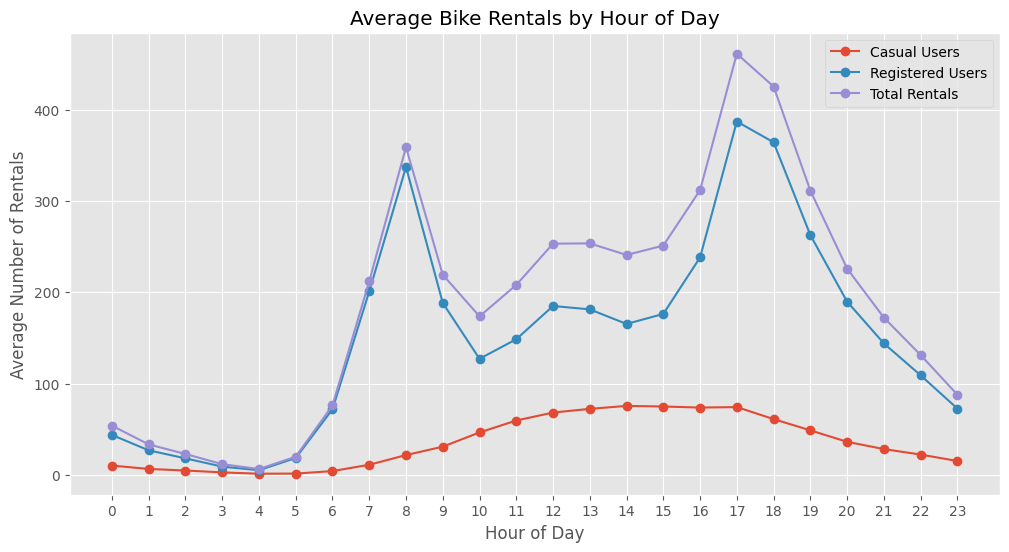

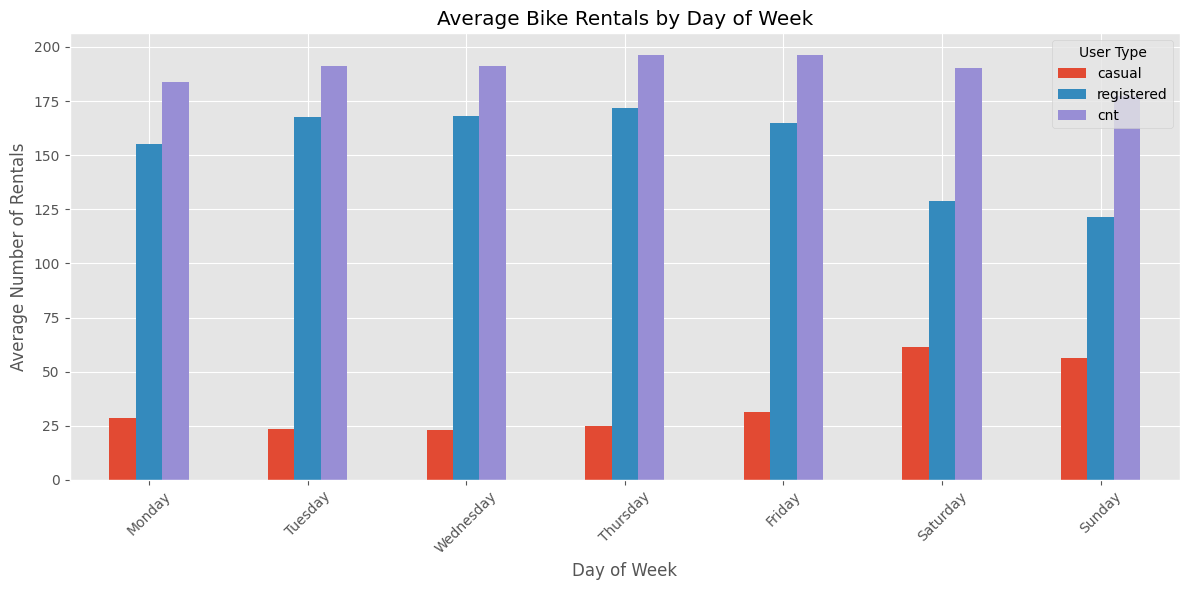

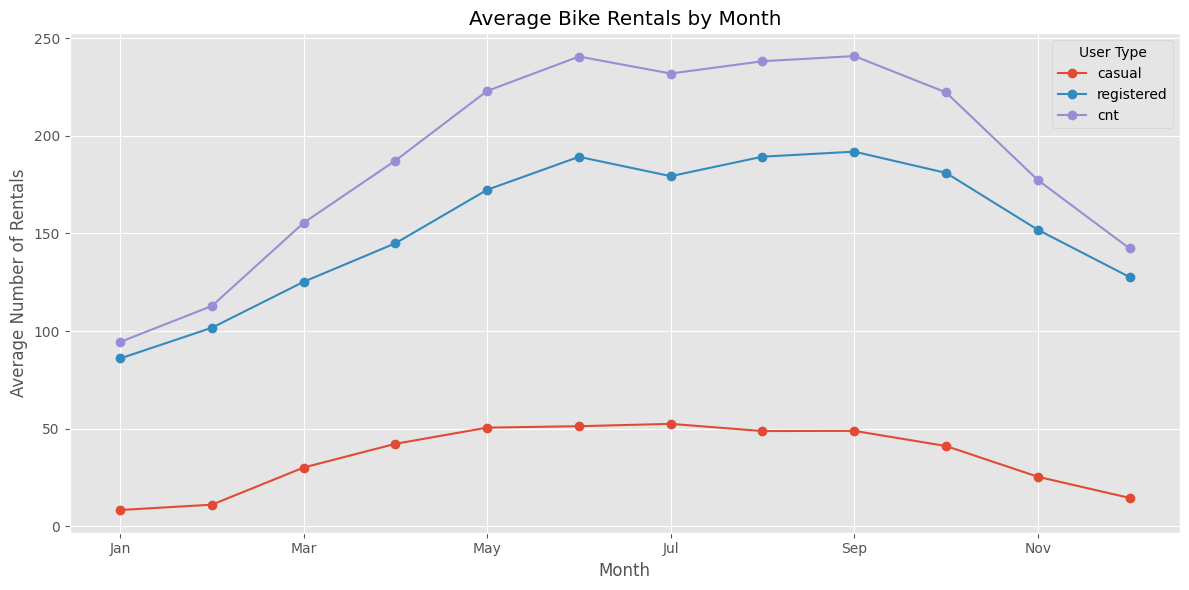

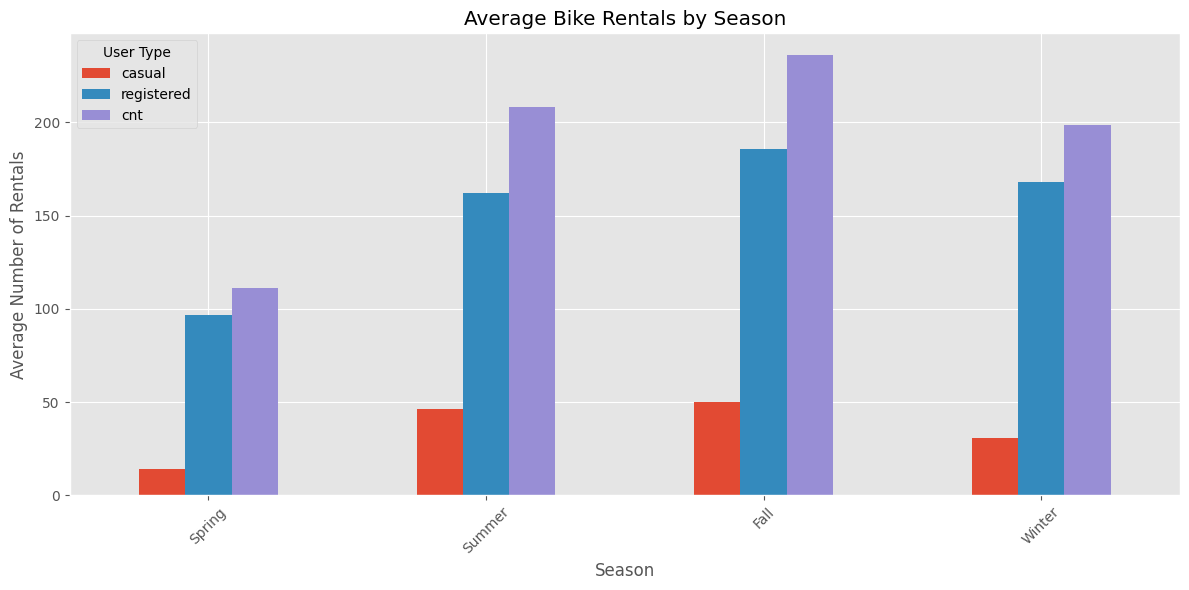

In [15]:
# HOURLY ANALYSIS
hourly_data = data.groupby('hr')[['casual', 'registered', 'cnt']].mean()
plt.figure(figsize=(12, 6))
plt.plot(hourly_data.index, hourly_data['casual'], 'o-', label='Casual Users')
plt.plot(hourly_data.index, hourly_data['registered'], 'o-', label='Registered Users')
plt.plot(hourly_data.index, hourly_data['cnt'], 'o-', label='Total Rentals')
plt.xlabel('Hour of Day')
plt.ylabel('Average Number of Rentals')
plt.title('Average Bike Rentals by Hour of Day')
plt.legend()
plt.grid(True)
plt.xticks(range(0, 24))
plt.show()

# DAY OF WEEK ANALYSIS
weekday_names = {
    0: 'Sunday', 1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday'
}
data['weekday_name'] = data['weekday'].map(weekday_names)
weekday_data = data.groupby('weekday_name')[['casual', 'registered', 'cnt']].mean()
weekday_data = weekday_data.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

plt.figure(figsize=(12, 6))
weekday_data.plot(kind='bar', ax=plt.gca())
plt.xlabel('Day of Week')
plt.ylabel('Average Number of Rentals')
plt.title('Average Bike Rentals by Day of Week')
plt.legend(title='User Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# MONTHLY ANALYSIS
month_names = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
              7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
data['month_name'] = data['mnth'].map(month_names)
monthly_data = data.groupby('month_name')[['casual', 'registered', 'cnt']].mean()
monthly_data = monthly_data.reindex(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

plt.figure(figsize=(12, 6))
monthly_data.plot(kind='line', marker='o', ax=plt.gca())
plt.xlabel('Month')
plt.ylabel('Average Number of Rentals')
plt.title('Average Bike Rentals by Month')
plt.legend(title='User Type')
plt.grid(True)
plt.tight_layout()
plt.show()

# SEASONAL ANALYSIS
season_names = {1: 'Spring', 2: 'Summer', 3: 'Fall', 4: 'Winter'}
data['season_name'] = data['season'].map(season_names)

seasonal_data = data.groupby('season_name')[['casual', 'registered', 'cnt']].mean()
# Reorder the index to follow seasonal order
seasonal_data = seasonal_data.reindex(['Spring', 'Summer', 'Fall', 'Winter'])

plt.figure(figsize=(12, 6))
seasonal_data.plot(kind='bar', ax=plt.gca())
plt.xlabel('Season')
plt.ylabel('Average Number of Rentals')
plt.title('Average Bike Rentals by Season')
plt.legend(title='User Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()